<h3> Importing the Datasets </h3>

In [2]:
import gc
import re
import string
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from collections import defaultdict

In [4]:
import tokenize
from wordcloud import STOPWORDS # pip install WordCloud

In [5]:
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

<h3> Learning the Dataset </h3>

In [6]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [8]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

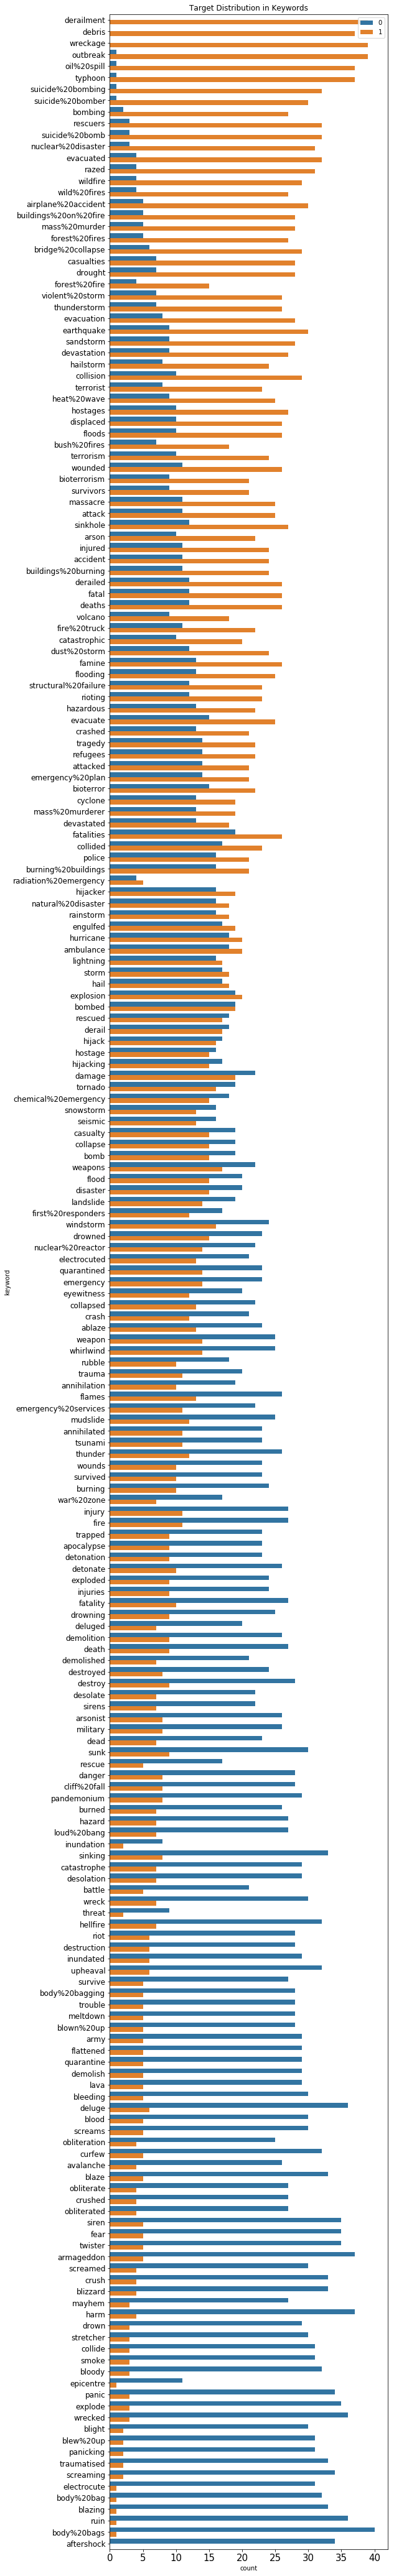

In [9]:
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 75))

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'])


plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target%_mean'], inplace=True)

<h3> Meta Features </h3>

In [10]:
# Word Count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# Unique Word Count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# Url Count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# Mean Word Length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# Character Count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# Punctuation Count
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Hashtag Count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# Mention Count
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

/Users/AngelinaKiman/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


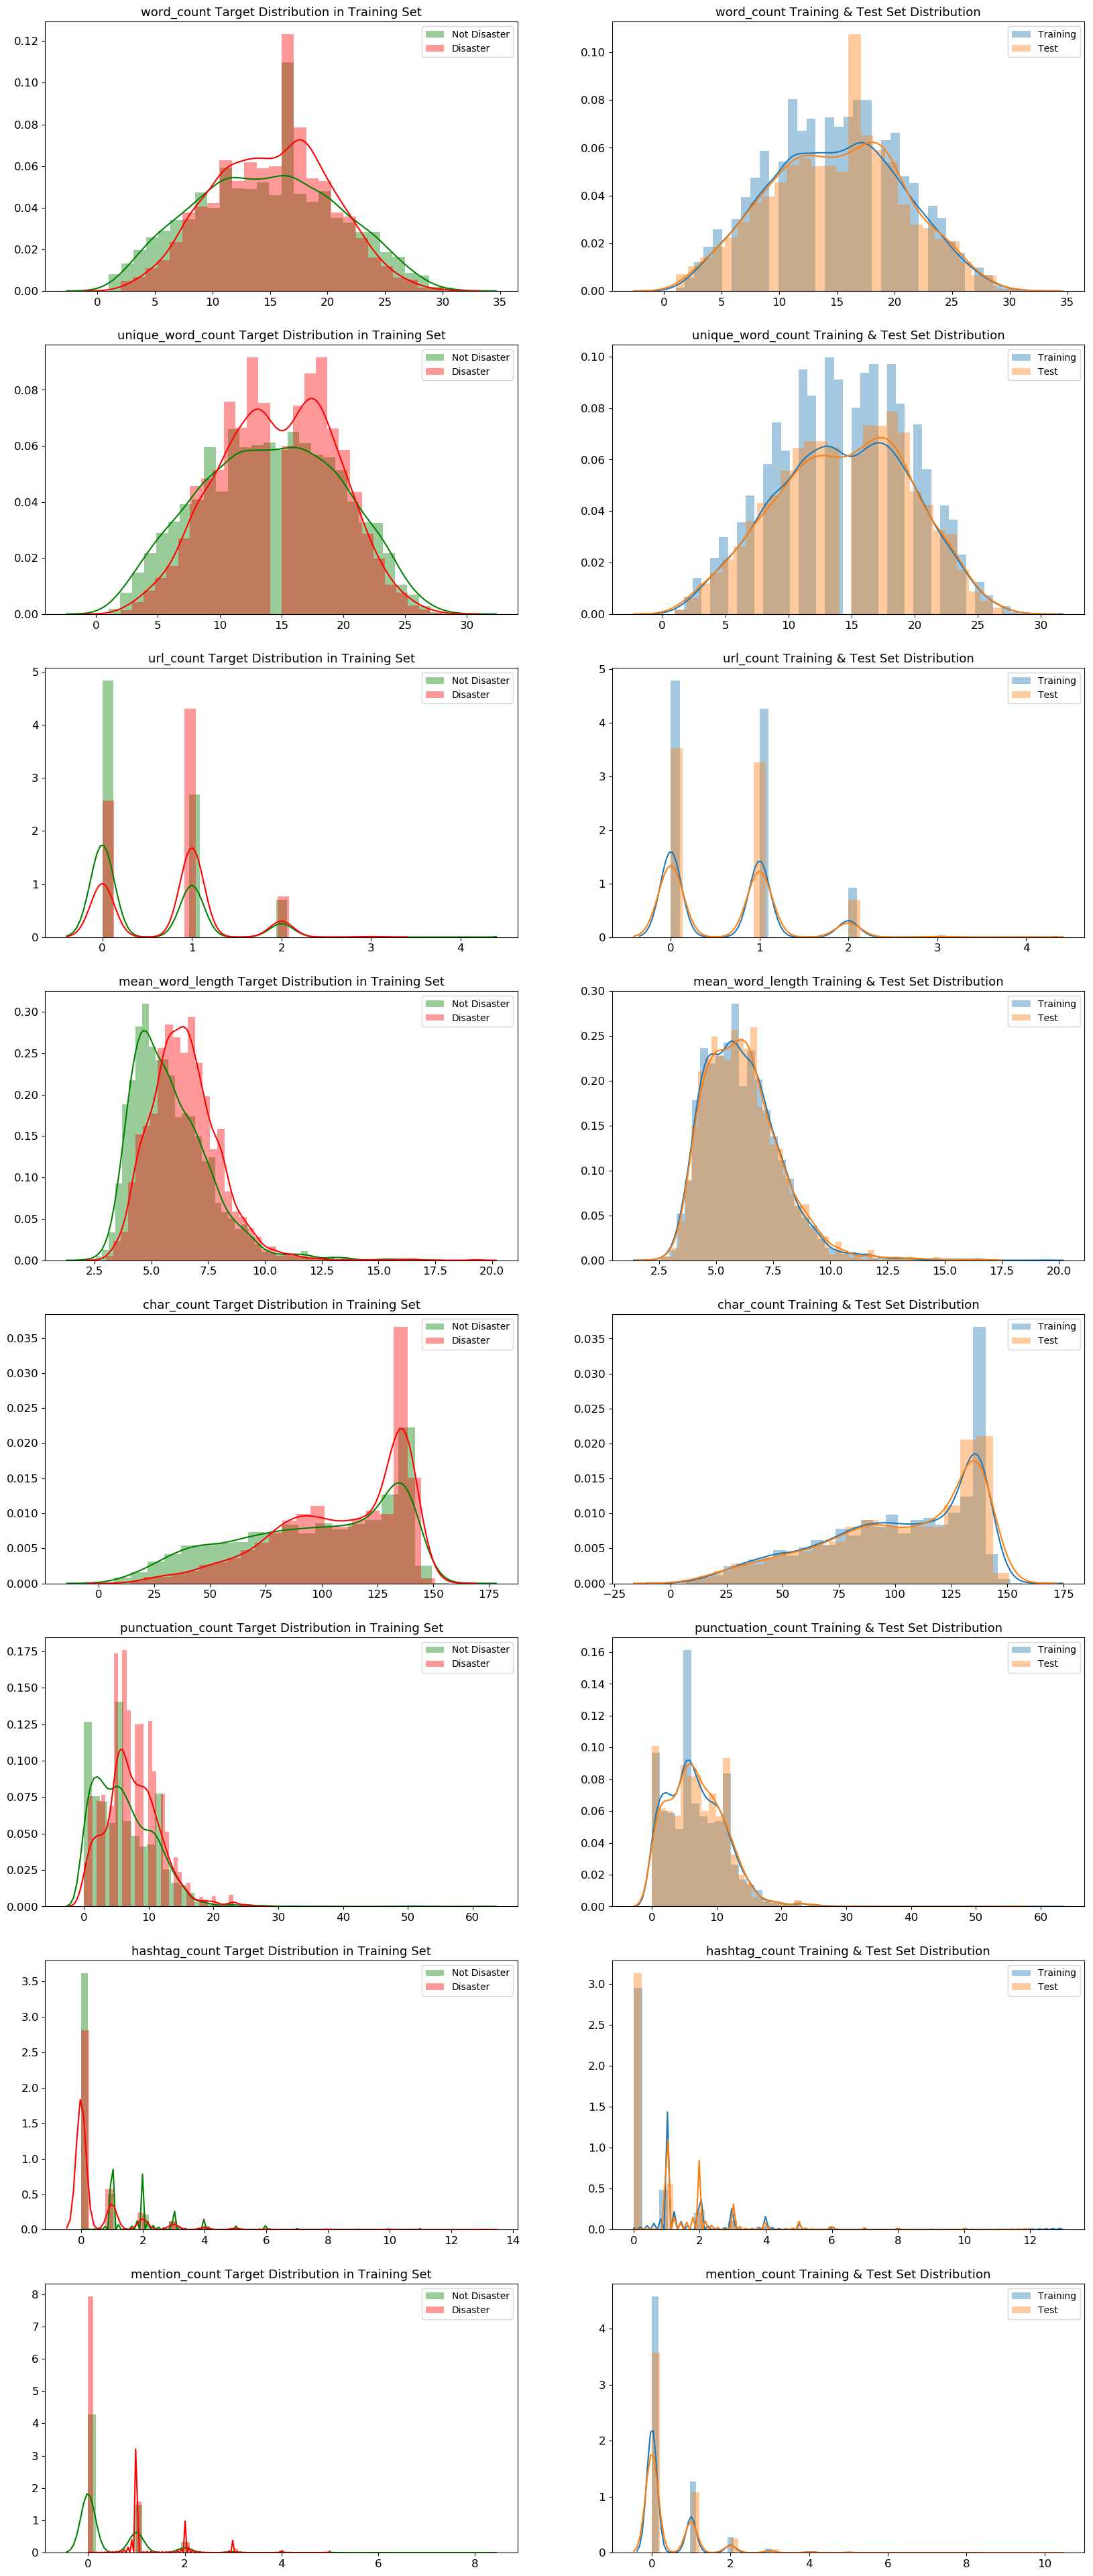

In [11]:
METAFEATURES = ['word_count', 'unique_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train[feature], label='Training', ax=axes[i][1])
    sns.distplot(test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

<h3> Target & N-grams </h3>

Class distributions are 57% for 0 (Not Disaster) and 43% for 1 (Disaster). Classes are almost equally separated so they don't require any stratification by target in cross-validation.

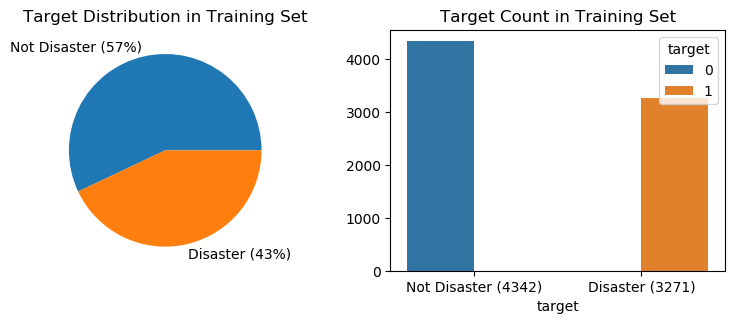

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3), dpi=100)
plt.tight_layout()

train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=train['target'], hue=train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)
axes[1].tick_params(axis='x', labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)

axes[0].set_title('Target Distribution in Training Set', fontsize=12)
axes[1].set_title('Target Count in Training Set', fontsize=12)

plt.show()

In [13]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

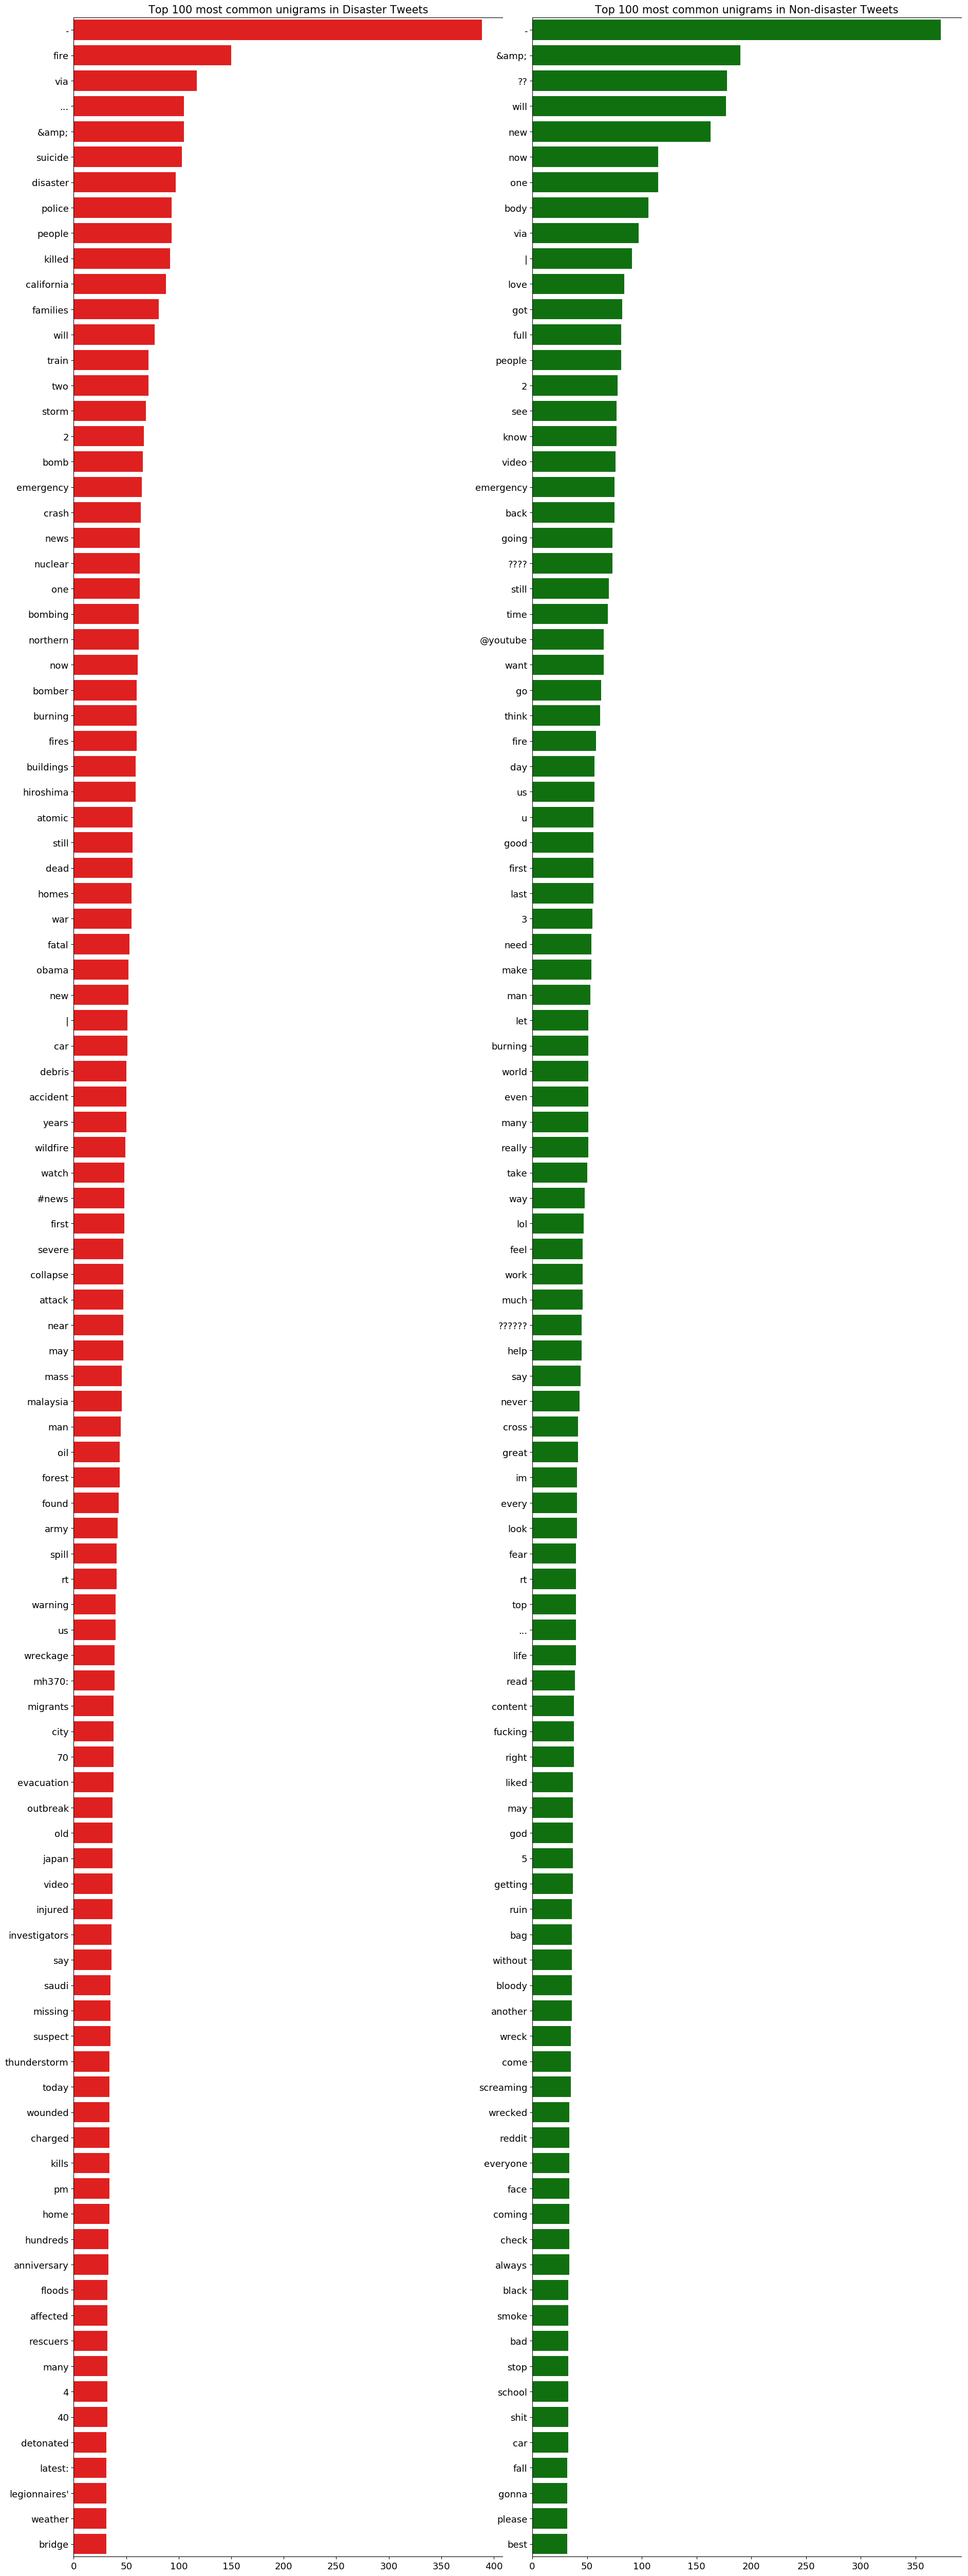

In [14]:
# Unigrams
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

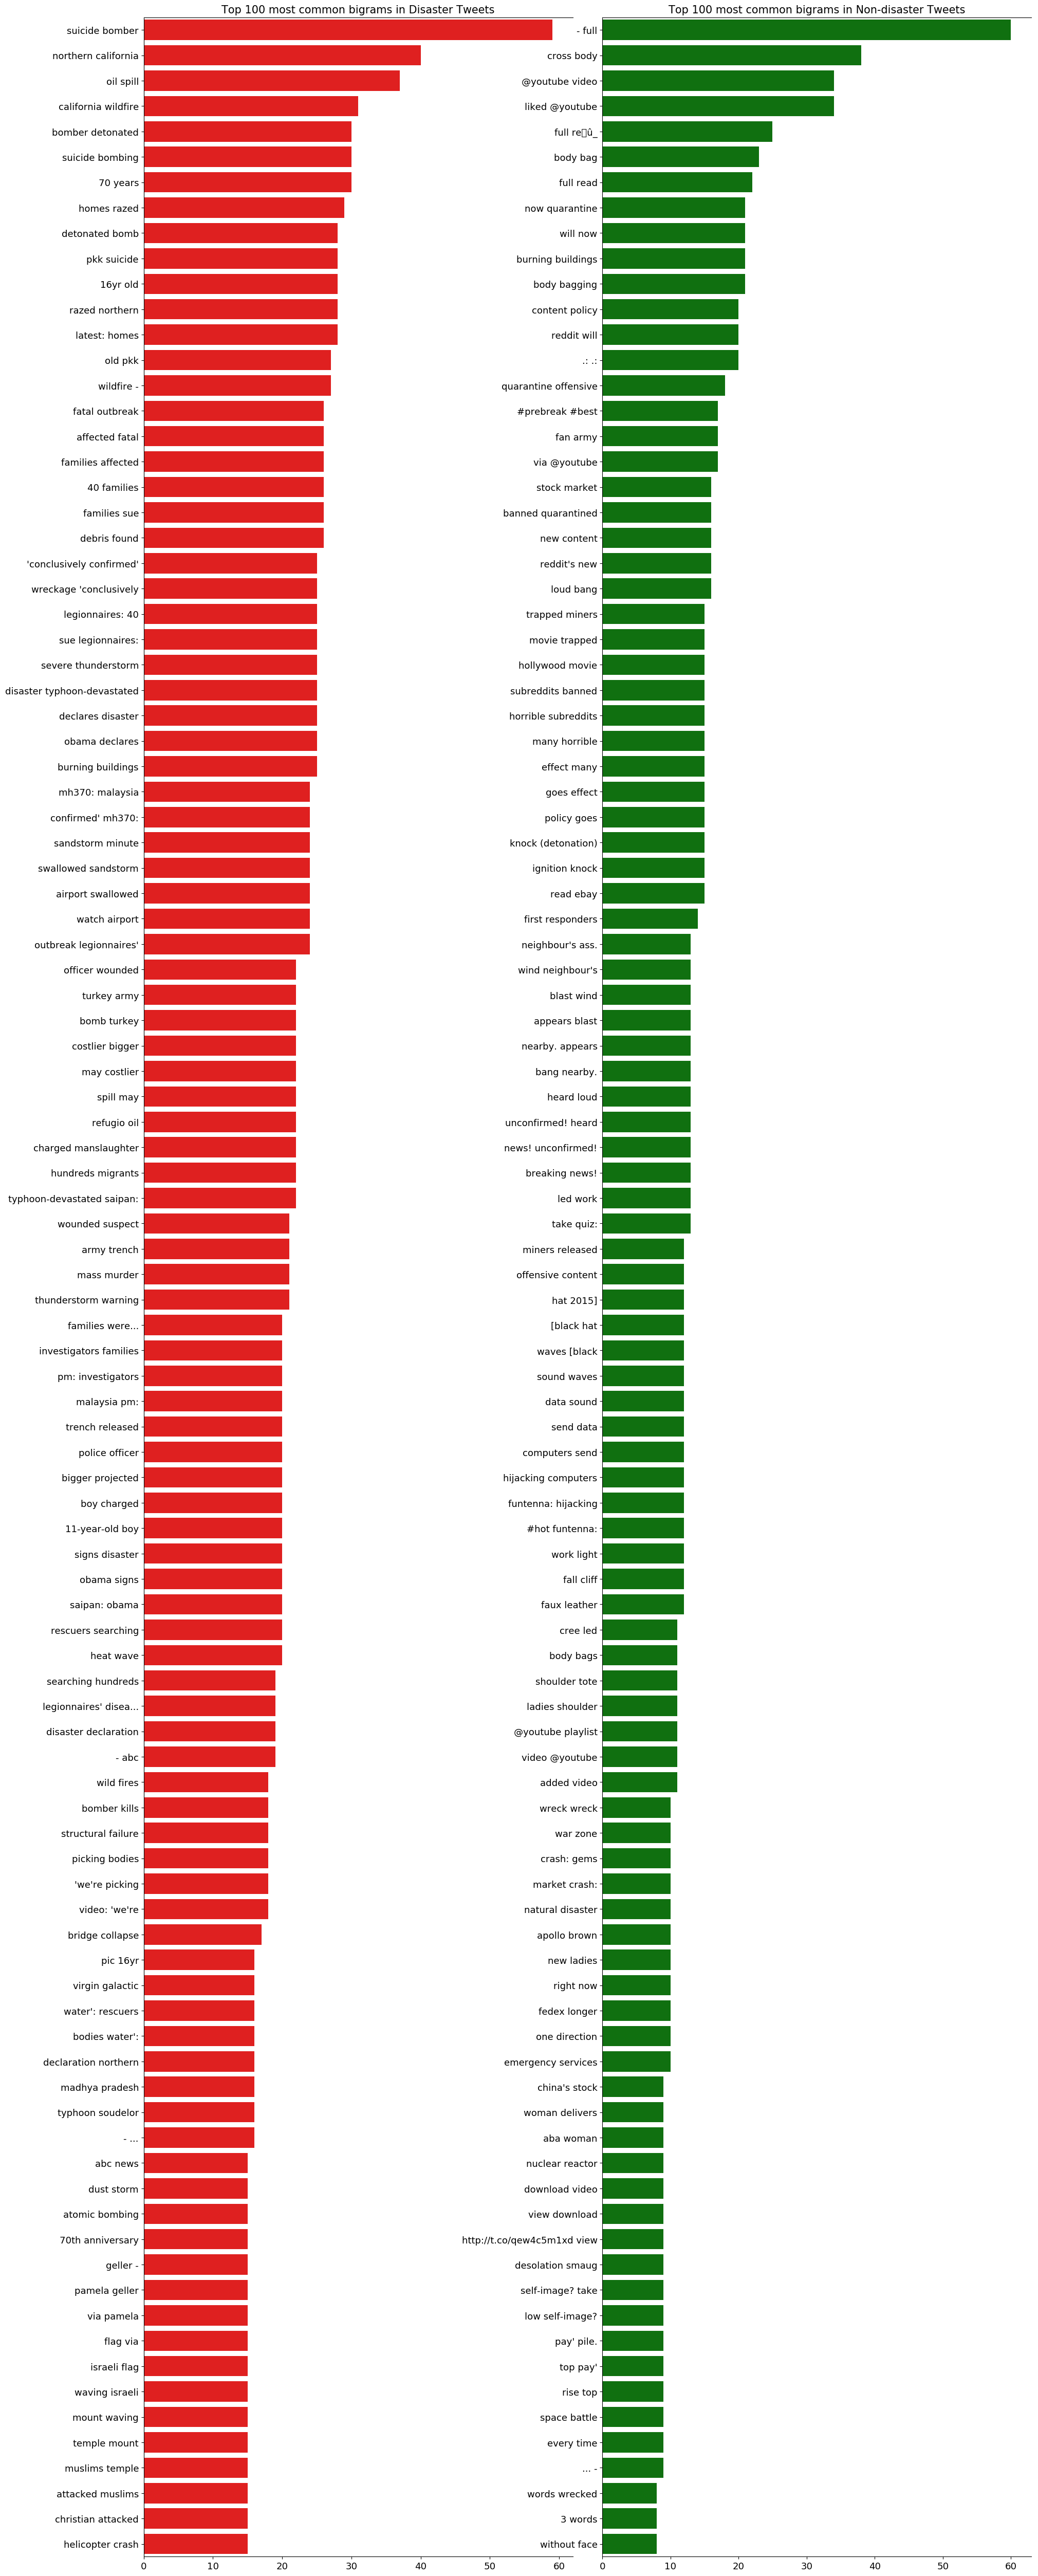

In [15]:
# Bigrams
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

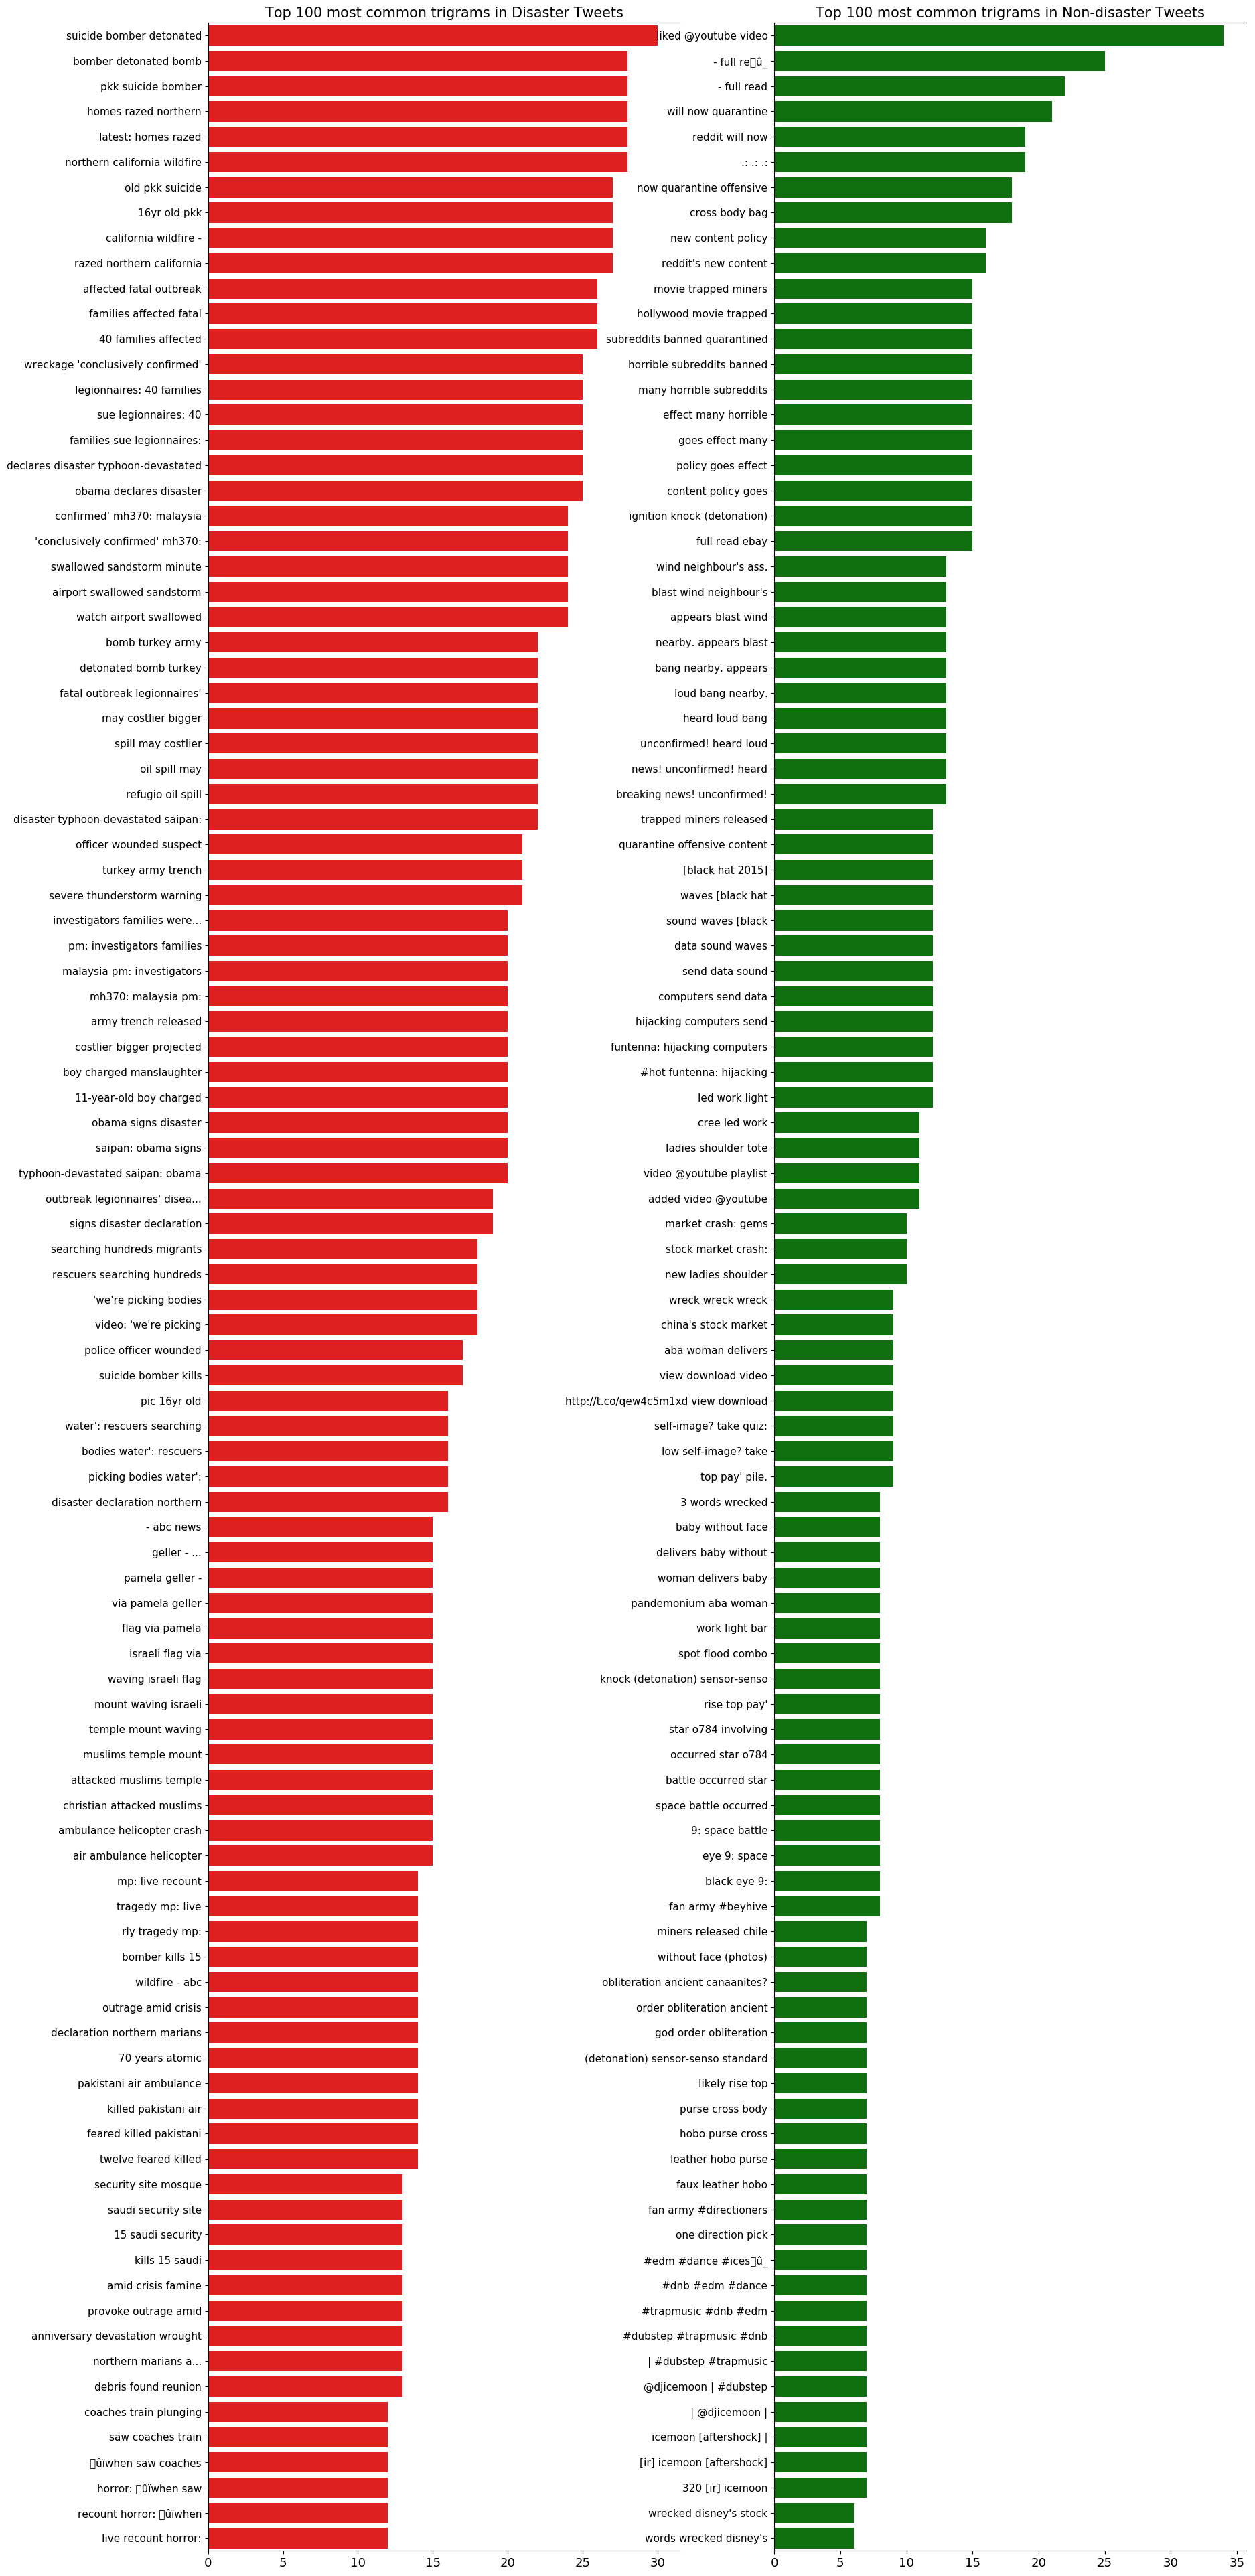

In [16]:
#Trigrams
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

In [17]:
# Downloading Stopwords
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Setting up Stopwords
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/AngelinaKiman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df=pd.concat([train,test])
df.shape

/Users/AngelinaKiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(10876, 13)

In [19]:
def create_corpus(target):
    corpus=[]
    
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 10 artists>

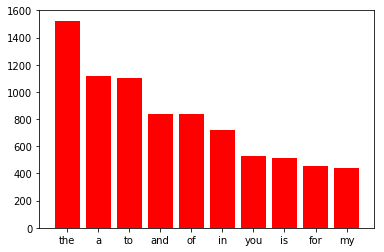

In [20]:
# # Analyzing stopwords for non-disaster (0) tweets 
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

# Show plot
x,y=zip(*top)
plt.bar(x,y, color='red')

<BarContainer object of 10 artists>

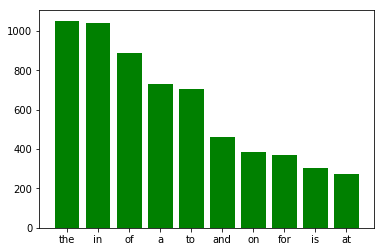

In [21]:
# # Analyzing stopwords for non-disaster (1) tweets 
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

# Show plot
x,y=zip(*top)
plt.bar(x,y, color='green')

<BarContainer object of 18 artists>

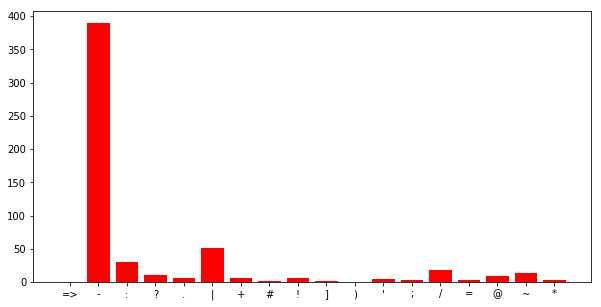

In [22]:
# Analyzing punctuations for disaster tweet
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y, color='red')

<BarContainer object of 20 artists>

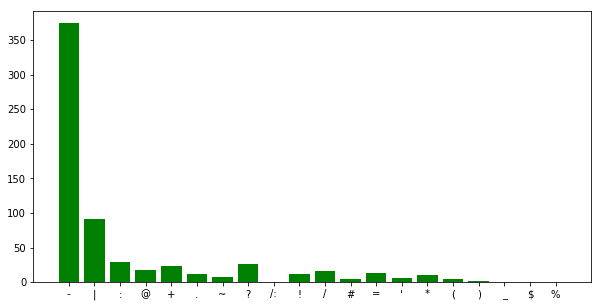

In [23]:
# Analyzing punctuations for non-disaster tweet
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y, color='green')

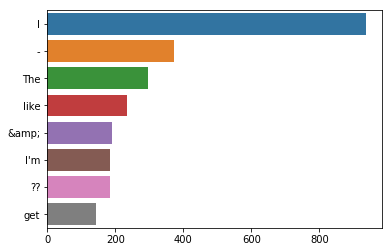

In [24]:
from collections import  Counter

counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

Based on the two charts above, "the" is the dominating word which followed by "a" in class 0 and "in" in class 1.

<h3> Data Cleaning </h3>

<h5> Removing URLs</h5>

In [25]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [26]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [27]:
train['text']=train['text'].apply(lambda x : remove_URL(x))

<h5> Remove HTML </h5>

In [28]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [29]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [30]:
train['text']=train['text'].apply(lambda x : remove_html(x))

<h5> Removing Emojis </h5>

In [31]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Oh Lord another Earthquake 😔😔")

'Oh Lord another Earthquake '

In [32]:
train['text']=train['text'].apply(lambda x: remove_emoji(x))

<h5> Removing Punctuations </h5>

In [33]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a member of #SDSA"
print(remove_punct(example))

I am a member of SDSA


In [34]:
train['text']=train['text'].apply(lambda x : remove_punct(x))

<h3> WorldCloud </h3>

In [35]:
from wordcloud import WordCloud

In [36]:
def create_corpus_train(tweet, target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [37]:
# Generating the wordcloud for disaster tweets
corpus_new1=create_corpus_train(train,1)
len(corpus_new1)

46269

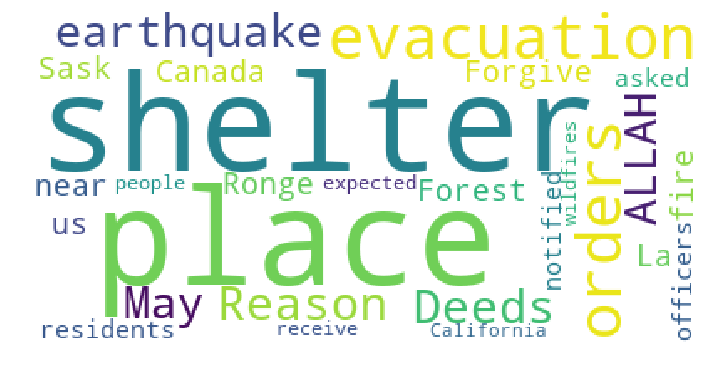

In [38]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [39]:
# Generating the wordcloud for non-disaster tweets
corpus_new0=create_corpus_train(train,0)
len(corpus_new0)

60478

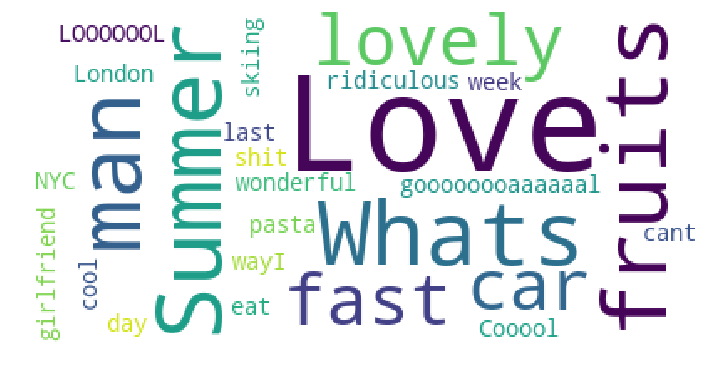

In [40]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new0[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [41]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [42]:
def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

<h3> Target Cleaning </h3>

In [43]:
def clean_tweets(train):
    """Removes links and non-ASCII characters"""
    
    train = ''.join([x for x in tweet if x in string.printable])
    
    # Removing URLs
    train = re.sub(r"http\S+", "", train)
    
    return train

In [44]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [45]:
def remove_punctuations(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    
    if '...' not in text:
        text = text.replace('..', ' ... ')
    
    return text

In [46]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [47]:
target_corrected = True
target_big_corrected = False

In [48]:
if target_corrected:
    ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
    train.loc[train['id'].isin(ids_with_target_error),'target'] = 0
    train[train['id'].isin(ids_with_target_error)]

In [49]:
if target_big_corrected:
    train["text"] = train["text"].apply(lambda x: clean_tweets(x))
    test["text"] = test["text"].apply(lambda x: clean_tweets(x))
    
    train["text"] = train["text"].apply(lambda x: remove_emoji(x))
    test["text"] = test["text"].apply(lambda x: remove_emoji(x))
    
    train["text"] = train["text"].apply(lambda x: remove_punctuations(x))
    test["text"] = test["text"].apply(lambda x: remove_punctuations(x))
    
    train["text"] = train["text"].apply(lambda x: convert_abbrev_in_text(x))
    test["text"] = test["text"].apply(lambda x: convert_abbrev_in_text(x))

<h3> Splitting the Train Dataset </h3>

In [50]:
# Import Train-Test-Split
from sklearn.model_selection import train_test_split

In [51]:
# Splitting the train dateset into two disparate datasets (one for train dataset, the other for test the dataset)
x_train, x_test, y_train, y_test = train_test_split(train['text'], train['target']) 

<h3> Vectorizing the Train Datasets </h3>

In [52]:
# Import Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [53]:
# Initializing Vectorizer
vect = TfidfVectorizer()

In [54]:
# Learning the vocab inside the datasets and transforms the train's dataset into matrix 
x_train_vect = vect.fit_transform(x_train)
x_test_vect = vect.transform(x_test)

<h3> Classifying Each Tweet Through Machine Learning </h3>

<h4>Model 1: Naive Bayes</h4>

In [55]:
# Importing Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
# Estimating the accuracy of the model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
nb_model = MultinomialNB()
# Train the dataset
nb_model.fit(x_train_vect, y_train)
# Predicting the target (0 is non-disaster, 1 is disater tweet)
nb_predict = nb_model.predict(x_test_vect)
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, nb_predict))
print("")
# Classification Report & Accuracy Score
print("Classification Report:")
print(classification_report(y_test, nb_predict))
print("accuracy:", (accuracy_score(y_test, nb_predict)))

Confusion Matrix:
[[1015   67]
 [ 331  491]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.84      1082
           1       0.88      0.60      0.71       822

   micro avg       0.79      0.79      0.79      1904
   macro avg       0.82      0.77      0.77      1904
weighted avg       0.81      0.79      0.78      1904

accuracy: 0.7909663865546218


<h4>Model 2: Logistic Regression</h4>

This has the <b>highest accuracy rate and f1-score</b> out of all 6 models, and will be used to predict the test data.

In [56]:
# Importing Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver="liblinear")
# Train the dataset
lr_model.fit(x_train_vect, y_train)
# Predicting the target (0 is non-disaster, 1 is disaster tweet)
lr_predict = lr_model.predict(x_test_vect)
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, lr_predict))
print("")
# Classification Report & Accuracy Score
print("Classification Report:")
print(classification_report(y_test, lr_predict))
print("Accuracy:", (accuracy_score(y_test, lr_predict)))

Confusion Matrix:
[[982 100]
 [271 551]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1082
           1       0.85      0.67      0.75       822

   micro avg       0.81      0.81      0.81      1904
   macro avg       0.82      0.79      0.79      1904
weighted avg       0.81      0.81      0.80      1904

Accuracy: 0.8051470588235294


<h4>Model 3: Gradient Boosting</h4>

In [57]:
# Importing Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(loss='exponential', learning_rate=0.03, n_estimators=75 , max_depth=6)
# Train the dataset
gb_model.fit(x_train_vect, y_train)
# Predicting the target (0 is non-disaster, 1 is disaster tweet)
gb_predict = gb_model.predict(x_test_vect)
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, gb_predict))
print("")
# Classification Report & Accuracy Score
print("Classification Report:")
print(classification_report(y_test, gb_predict))
print("Accuracy:", (accuracy_score(y_test, gb_predict)))

Confusion Matrix:
[[972 110]
 [443 379]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78      1082
           1       0.78      0.46      0.58       822

   micro avg       0.71      0.71      0.71      1904
   macro avg       0.73      0.68      0.68      1904
weighted avg       0.72      0.71      0.69      1904

Accuracy: 0.7095588235294118


<h4>Model 4: Decision Tree</h4>

In [58]:
# Importing Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
# Train the dataset
dt_model.fit(x_train_vect, y_train)
# Predicting the target (0 is non-disaster, 1 is disaster tweet)
dt_predict = dt_model.predict(x_test_vect)
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, dt_predict))
print("")
# Classification Report & Accuracy Score
print("Classification Report:")
print(classification_report(y_test, dt_predict))
print("Accuracy:", (accuracy_score(y_test, dt_predict)))

Confusion Matrix:
[[811 271]
 [275 547]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1082
           1       0.67      0.67      0.67       822

   micro avg       0.71      0.71      0.71      1904
   macro avg       0.71      0.71      0.71      1904
weighted avg       0.71      0.71      0.71      1904

Accuracy: 0.7132352941176471


<h4>Model 5: K Nearest Neighbors</h4>

In [59]:
# Importing K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=10)
# Train the dataset
knn_model.fit(x_train_vect, y_train)
# Predicting the target (0 is non-disaster, 1 is disaster tweet)
knn_predict = knn_model.predict(x_test_vect)
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, knn_predict))
print("")
# Classification Report & Accuracy Score
print("Classification Report:")
print(classification_report(y_test, knn_predict))
print("Accuracy:", (accuracy_score(y_test, knn_predict)))

Confusion Matrix:
[[986  96]
 [328 494]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1082
           1       0.84      0.60      0.70       822

   micro avg       0.78      0.78      0.78      1904
   macro avg       0.79      0.76      0.76      1904
weighted avg       0.79      0.78      0.77      1904

Accuracy: 0.7773109243697479


<h4>Model 6: Random Forest</h4>

In [60]:
# Importing Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100)
# Train the dataset
rf_model.fit(x_train_vect, y_train)
# Predicting the target (0 is non-disaster, 1 is disaster tweet)
rf_predict = rf_model.predict(x_test_vect)
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_predict))
print("")
# Classification Report & Accuracy Score
print("Classification Report:")
print(classification_report(y_test, rf_predict))
print("Accuracy:", (accuracy_score(y_test, rf_predict)))

Confusion Matrix:
[[999  83]
 [326 496]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83      1082
           1       0.86      0.60      0.71       822

   micro avg       0.79      0.79      0.79      1904
   macro avg       0.81      0.76      0.77      1904
weighted avg       0.80      0.79      0.78      1904

Accuracy: 0.7851890756302521


<h3> Predicting the Target for the Test Dataset </h3>

In [61]:
# Cleaning the test dataset the same way train dataset is prepared.
test['text']=test['text'].apply(lambda x : remove_URL(x)) 
test['text']=test['text'].apply(lambda x : remove_html(x))
test['text']=test['text'].apply(lambda x: remove_emoji(x))
test['text']=test['text'].apply(lambda x : remove_punct(x))
test.head()

,id,keyword,location,text,word_count,unique_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,0,NaN,NaN,Just happened a terrible car crash,6,6,0,4.833333,34,0,0,0
1,2,NaN,NaN,Heard about earthquake is different cities sta...,9,9,0,6.222222,64,3,1,0
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,19,19,0,4.105263,96,2,0,0
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires,4,4,0,9.250000,40,3,2,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,8,8,0,4.750000,45,0,0,0


In [62]:
# Transforming the tweets into matrix
text_test_trans = vect.transform(test['text'])

In [63]:
# Predicting tweets
result = lr_model.predict(text_test_trans)

In [64]:
# Putting the result into the submission's dataframe
sample_submission['target'] = result

Now, here is the dataframe after the target was included into it.

In [65]:
sample_submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [66]:
sample_submission.tail()

,id,target
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
3262,10875,0


Change the dataframe into a CSV file for submission

In [67]:
sample_submission.to_csv('submission.csv', index = False)